# Smoothing spatial data

In [1]:
import scanpy as sc
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sns

from tqdm import tqdm_notebook

from scipy import ndimage

In [2]:
sc.set_figure_params(dpi=100)

## Read HD-ST data

In [3]:
adata = sc.read('results/hdst.h5ad')
adata._sanitize()
adata

... storing 'region' as categorical
... storing 'segment' as categorical


AnnData object with n_obs × n_vars = 874864 × 16208 
    obs: 'region', 'segment', 'x', 'y'
    var: 'gene_symbols', 'gene_ids'
    uns: 'region_colors'
    obsm: 'X_spatial', '5x'

In [4]:
adata_binned = sc.read('results/hdst-lowres-5x.h5ad')
adata_binned

AnnData object with n_obs × n_vars = 60288 × 16208 
    obs: 'x', 'y', 'Ependymal Cell Zone (E)', 'External Plexiform Layer (EPL)', 'Glomerular Layer (GL)', 'Granule Cell Layer External (GCL-E)', 'Granule Cell Layer Internal (GCL-I)', 'Internal Plexiform Layer (IPL)', 'Mitral Layer (M/T)', 'ND', 'Olfactory Nerve Layer (ONL)', 'Rostral Migratory System (RMS)'
    var: 'gene_symbols', 'gene_ids'

In [9]:
categories = adata.obs['region'].cat.categories.values
categories

array(['Ependymal Cell Zone (E)', 'External Plexiform Layer (EPL)',
       'Glomerular Layer (GL)', 'Granule Cell Layer External (GCL-E)',
       'Granule Cell Layer Internal (GCL-I)',
       'Internal Plexiform Layer (IPL)', 'Mitral Layer (M/T)', 'ND',
       'Olfactory Nerve Layer (ONL)', 'Rostral Migratory System (RMS)'],
      dtype=object)

In [10]:
best_cat = adata_binned.obs.loc[:, categories].values.argmax(axis=1)
valid_obs = adata_binned.obs.loc[:, categories].sum(1) > 0.0

adata_binned = adata_binned[valid_obs].copy()
best_cat = best_cat[valid_obs]

adata_binned.obs['region'] = categories[best_cat]
adata_binned.obs['region'] = adata_binned.obs['region'].astype('category')
adata_binned

AnnData object with n_obs × n_vars = 35289 × 16208 
    obs: 'x', 'y', 'Ependymal Cell Zone (E)', 'External Plexiform Layer (EPL)', 'Glomerular Layer (GL)', 'Granule Cell Layer External (GCL-E)', 'Granule Cell Layer Internal (GCL-I)', 'Internal Plexiform Layer (IPL)', 'Mitral Layer (M/T)', 'ND', 'Olfactory Nerve Layer (ONL)', 'Rostral Migratory System (RMS)', 'region'
    var: 'gene_symbols', 'gene_ids'

In [11]:
def get_gene_images(adata, g, layer=None):
    if layer is None:
        return sp.sparse.coo_matrix((adata[:, g].X, (adata.obs.y, adata.obs.x))).toarray()
    else:
        return sp.sparse.coo_matrix((adata[:, g].layers[layer], (adata.obs.y, adata.obs.x))).toarray()

def smooth_adata(adata, layer_name, sigma=1):
    
    from scipy import ndimage

    if sp.sparse.issparse(adata.X):
        adata.layers[layer_name] = adata.X.toarray()
    else:
        adata.layers[layer_name] = adata.X.copy()
    
    for i, g in enumerate(tqdm_notebook(adata.var_names)):
        img = sp.sparse.coo_matrix((adata[:, g].X,(adata.obs.x, adata.obs.y))).toarray()
        img2 = ndimage.gaussian_filter(img, sigma)
        img2 = (img2/img2.max()) * img.max()
        adata.layers[layer_name][:, i] = img2[adata.obs.x, adata.obs.y]
  
    return adata

def smooth_adata_groupwise(adata, layer_name, cat_name, sigma=1):
    
    from scipy import ndimage

    if sp.sparse.issparse(adata.X):
        adata.layers[layer_name] = adata.X.toarray()
    else:
        adata.layers[layer_name] = adata.X.copy()
    
    for group in tqdm_notebook(adata.obs[cat_name].cat.categories):
        idx = np.where(adata.obs[cat_name] == group)[0]

        for i, g in enumerate(adata.var_names):
            img = sp.sparse.coo_matrix((adata[:, g].X[idx], (adata.obs.x[idx], adata.obs.y[idx]))).toarray()
            img2 = ndimage.gaussian_filter(img, sigma)
            img2 = (img2/img2.max()) * img.max() if img2.max() != 0 else img2
            adata.layers[layer_name][idx, i] = img2[adata.obs.x[idx], adata.obs.y[idx]]

    return adata

### Compare group-wise and overall smoothing on binned data

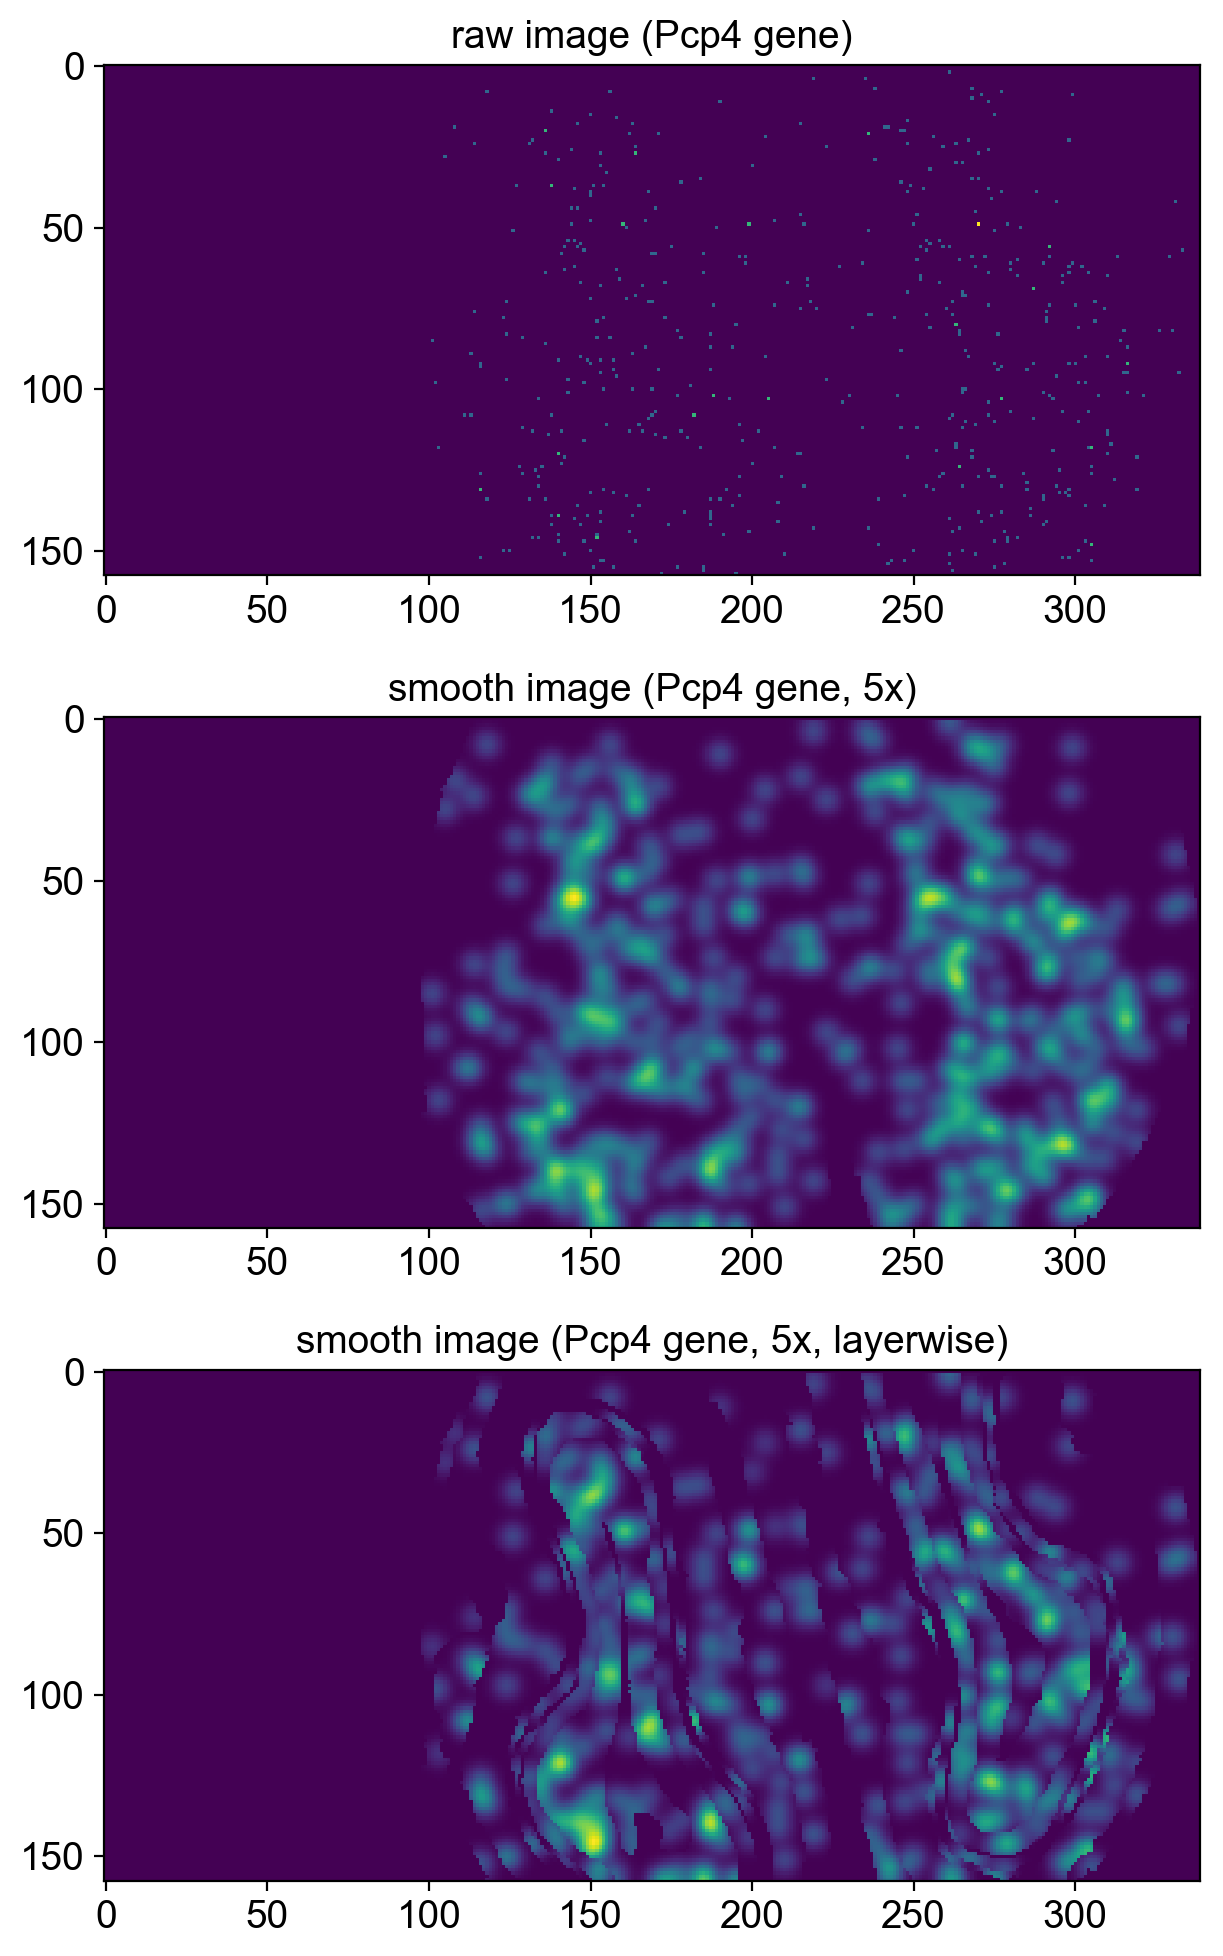

In [12]:
sigma = 3
factor = 5

genes = ['Kcnh3', 'Pcp4']
ad = adata_binned[:, genes].copy()

smooth_adata(ad, 'smooth_overall', sigma=sigma)
smooth_adata_groupwise(ad, 'smooth_groupwise', 'region', sigma=sigma)

plot_gene = 'Pcp4'

fig = plt.figure(figsize=(15, 10))

ax = plt.subplot(311)
plt.imshow(get_gene_images(adata_binned, plot_gene))
plt.title('raw image (%s gene)' % plot_gene)
ax.grid(False)

ax = plt.subplot(312)
plt.imshow(get_gene_images(ad, plot_gene, layer='smooth_overall'))
plt.title('smooth image (%s gene, %sx)' % (plot_gene, factor))
ax.grid(False)

ax = plt.subplot(313)
plt.imshow(get_gene_images(ad, plot_gene, layer='smooth_groupwise'))
plt.title('smooth image (%s gene, %sx, layerwise)' % (plot_gene, factor))
ax.grid(False)

plt.tight_layout()

### Perform smoothing for binned datasets

In [13]:
adata

AnnData object with n_obs × n_vars = 874864 × 16208 
    obs: 'region', 'segment', 'x', 'y'
    var: 'gene_symbols', 'gene_ids'
    uns: 'region_colors'
    obsm: 'X_spatial', '5x'

... storing 'region' as categorical


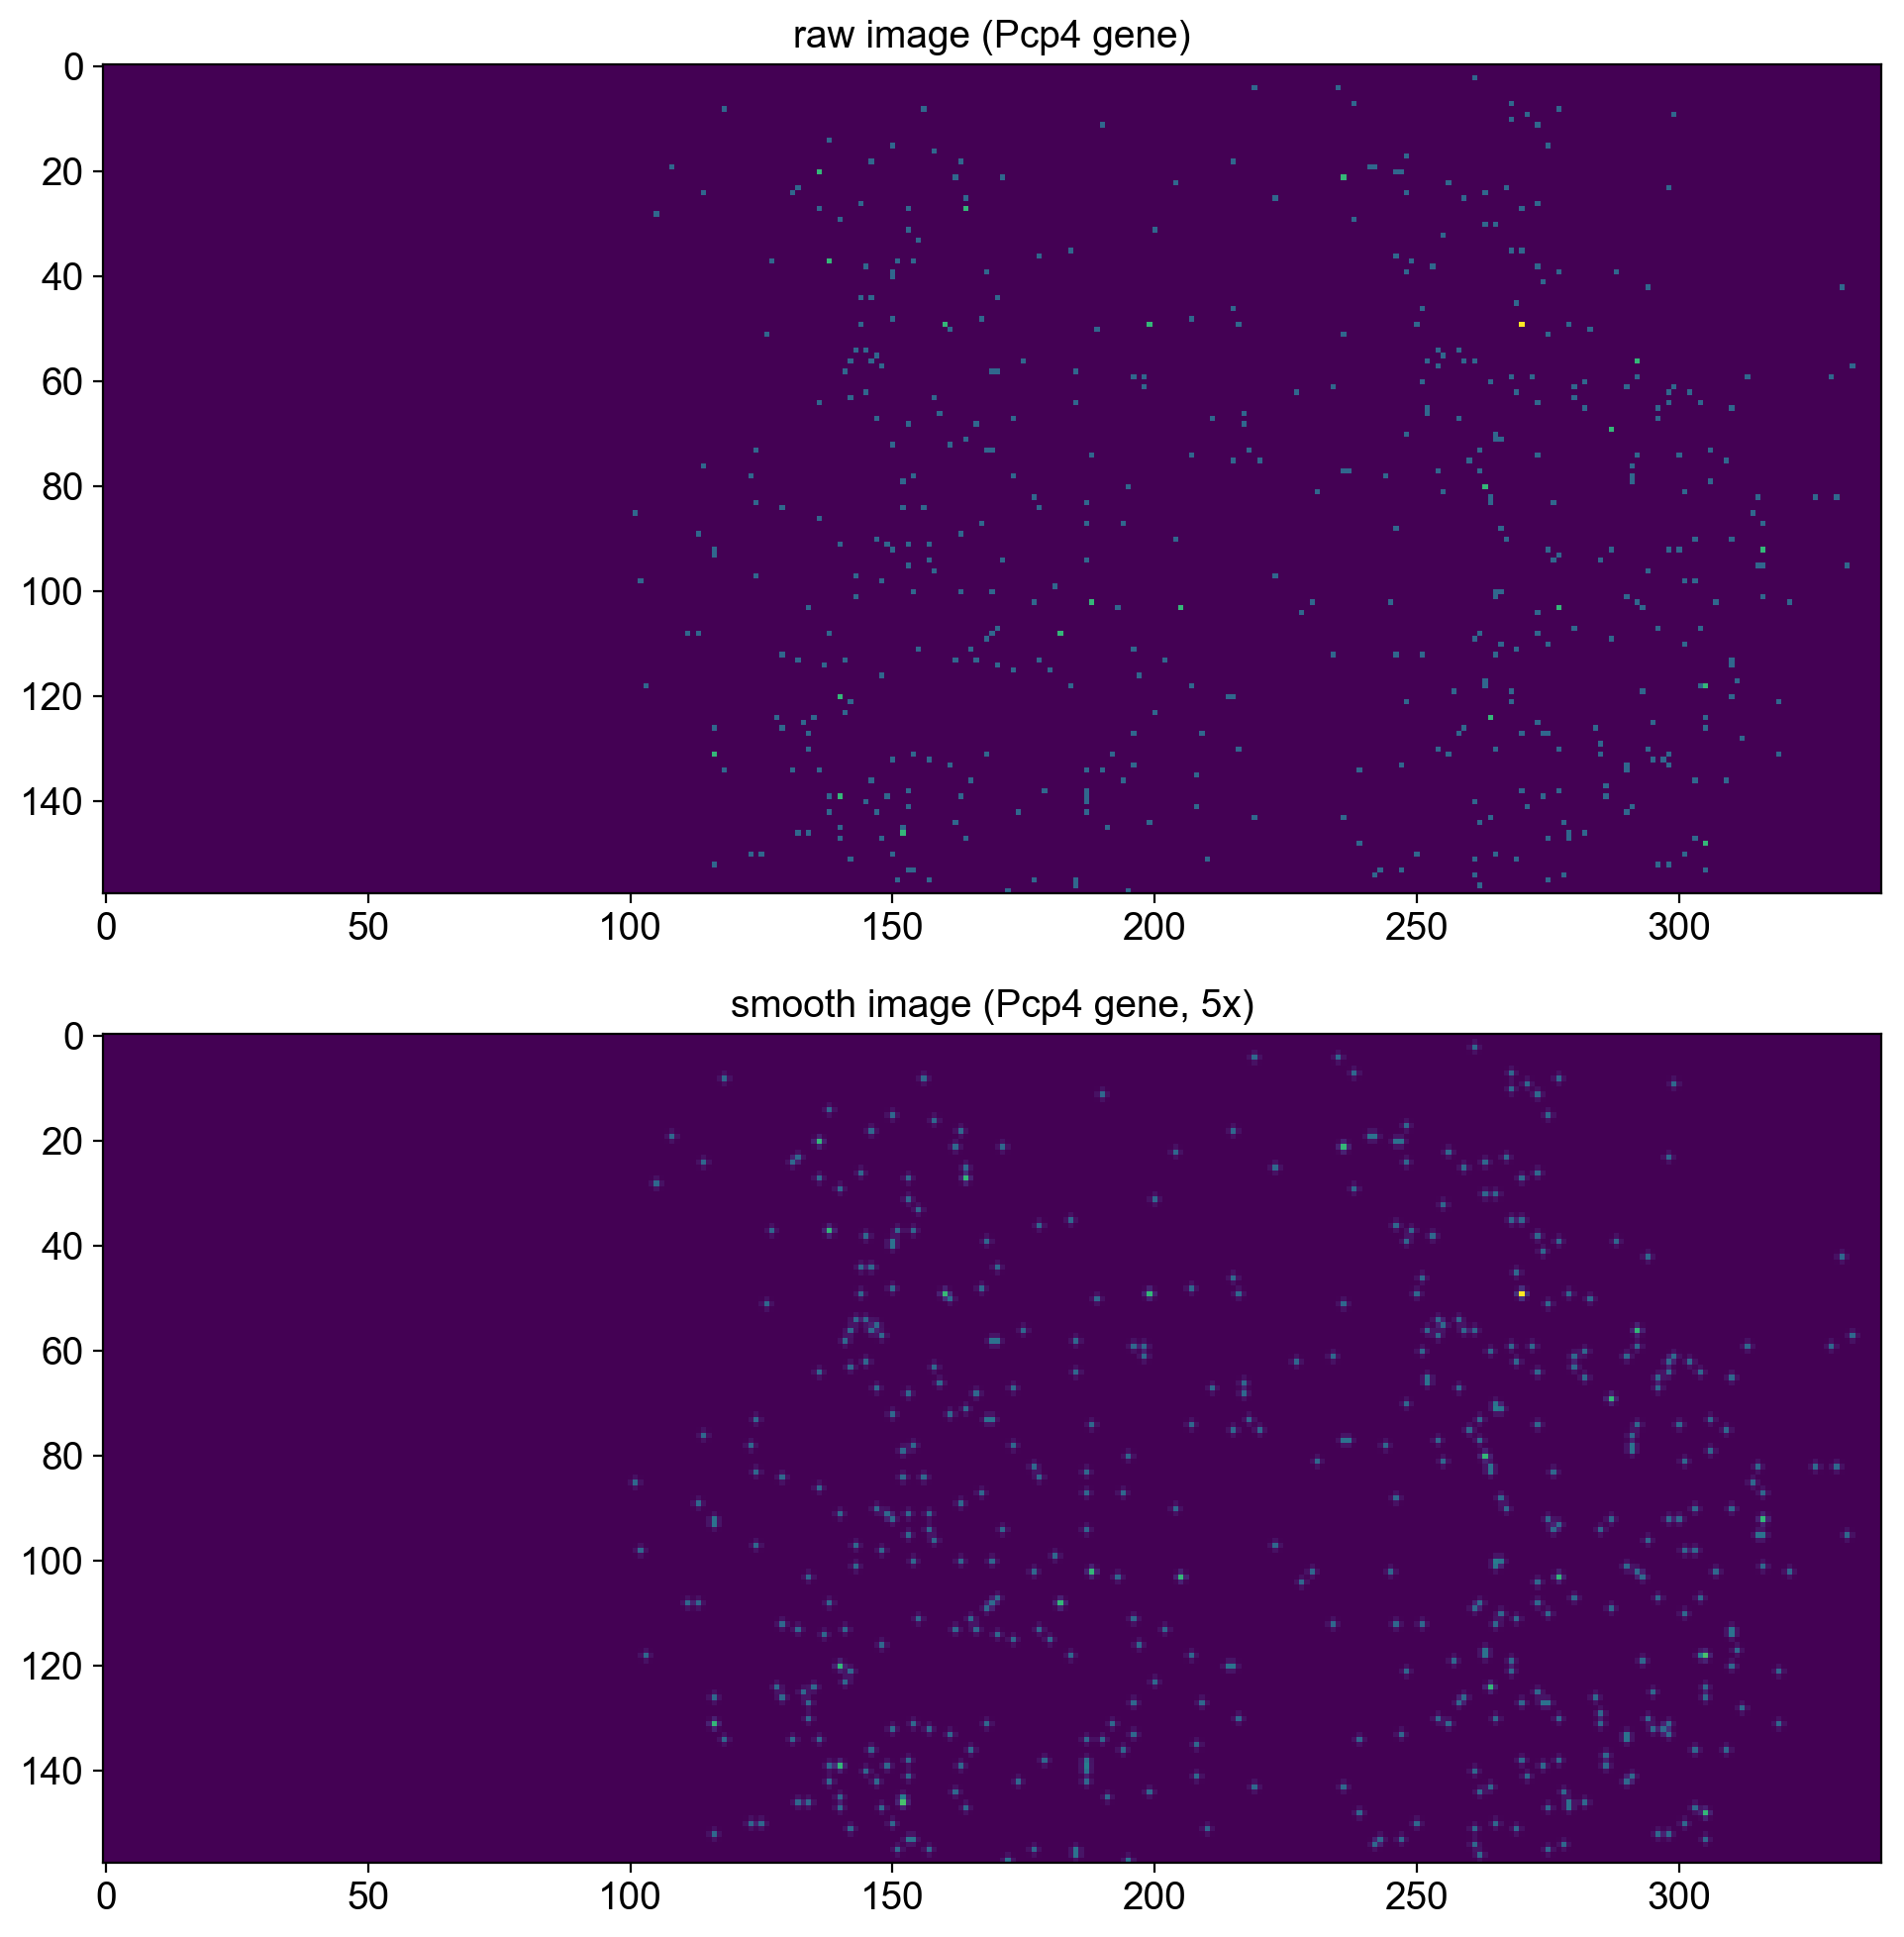

In [14]:
factors = (5, )
sigmas  = (0.5, )

for factor, sigma in zip(factors, sigmas):
    ad = sc.read('results/hdst-lowres-%sx.h5ad' % factor)
    
    best_cat = ad.obs.loc[:, categories].values.argmax(axis=1)
    valid_obs = ad.obs.loc[:, categories].sum(1) > 0.0
    ad = ad[valid_obs].copy()
    best_cat = best_cat[valid_obs]

    ad.obs['region'] = categories[best_cat]
    ad.obs['region'] = ad.obs['region'].astype('category')
    
    #sc.pp.normalize_per_cell(ad)
    
    smooth_adata(ad, 'smooth_overall', sigma=sigma)

    plot_gene = 'Pcp4'

    fig = plt.figure(figsize=(15, 10))

    ax = plt.subplot(211)
    plt.imshow(get_gene_images(adata_binned, plot_gene))
    plt.title('raw image (%s gene)' % plot_gene)
    ax.grid(False)

    ax = plt.subplot(212)
    plt.imshow(get_gene_images(ad, plot_gene, layer='smooth_overall'))
    plt.title('smooth image (%s gene, %sx)' % (plot_gene, factor))
    ax.grid(False)

    #ax = plt.subplot(313)
    #plt.imshow(get_gene_images(ad, plot_gene, layer='smooth_groupwise'))
    #plt.title('smooth image (%s gene, %sx, layerwise)' % (plot_gene, factor))
    #ax.grid(False)

    plt.tight_layout()

    ad.write('results/hdst-lowres-%sx-smooth-%ssigma.h5ad' % (factor, sigma))

In [6]:
factor = 5
sigma = 0.5
ad = sc.read('results/hdst-lowres-%sx-smooth-%ssigma.h5ad' % (factor, sigma))

In [7]:
ad

AnnData object with n_obs × n_vars = 35289 × 16208 
    obs: 'x', 'y', 'Ependymal Cell Zone (E)', 'External Plexiform Layer (EPL)', 'Glomerular Layer (GL)', 'Granule Cell Layer External (GCL-E)', 'Granule Cell Layer Internal (GCL-I)', 'Internal Plexiform Layer (IPL)', 'Mitral Layer (M/T)', 'ND', 'Olfactory Nerve Layer (ONL)', 'Rostral Migratory System (RMS)', 'region'
    var: 'gene_symbols', 'gene_ids'
    layers: 'smooth_overall'

In [19]:
ad

AnnData object with n_obs × n_vars = 35289 × 16208 
    obs: 'x', 'y', 'Ependymal Cell Zone (E)', 'External Plexiform Layer (EPL)', 'Glomerular Layer (GL)', 'Granule Cell Layer External (GCL-E)', 'Granule Cell Layer Internal (GCL-I)', 'Internal Plexiform Layer (IPL)', 'Mitral Layer (M/T)', 'ND', 'Olfactory Nerve Layer (ONL)', 'Rostral Migratory System (RMS)', 'region'
    var: 'gene_symbols', 'gene_ids'
    obsm: 'X_spatial'
    layers: 'smooth_overall'

In [20]:
adview = ad[ad.X.sum(1) > 0.]
adview[adview.X.sum(0) > 0.]

ArrayView([1.8509378e-04, 6.1697931e-05, 6.7867717e-04, ...,
           1.8509378e-04, 6.7867717e-04, 4.3188548e-04], dtype=float32)

In [10]:
pd.DataFrame(ad.layers['smooth_overall'], 
             columns=ad.var_names, 
             index=ad.obs_names).to_csv('results/hdst-lowres-5x-smooth-0.5sigma.csv.gz', compression='gzip', index=False)

In [9]:
ad.obs.to_csv('results/hdst-lowres-5x-smooth-0.5sigma-bins.csv.gz', compression='gzip', index=False)